# Try for Magnetar SGR 1935+2154

We first import the relevant modules:

In [1]:
#importamos en primer lugar los modulos que vayamos a usar
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base.transfer import EminGeV, EmaxGeV
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c

### Critical Energy of Conversion

In [2]:
m = 0.00396 # masa en microeV
B = 2.2e14 #el campo magnetico en Gauss

g = 1.01 #coupling constant 10^-11
M = 1/g #inverse coupling constant

In [3]:
Ecrit = ((m**2)*M)/(0.4*B)
print("La energía crítica de conversión es: ", Ecrit, "GeV")

La energía crítica de conversión es:  1.764356435643564e-19 GeV


### Photon Survival Probability

First, we need to set the ALP parameters:

In [4]:
m, g = 3.96, 1.01 #sacado del paper de MASC
alp = ALP(m, g)

Let's define an energy range for this example, in GeV.

In [5]:
EGeV = np.logspace(-20., -18., 500) #provisional, modificable

For the initial polarization, we'll use the following one:

In [6]:
pin = np.diag((1., 1., 0.))*0.5 #normalized

Let's generate the Source using the right parameters

In [7]:
src = Source(z=0.034, ra='19h34m55.6s', dec='+21d53m47.79s') #sacado del catalogo de magnetars

With the defined `alp`, `src`, initial polarization `pin` and energy range `EGeV`, we can now initialize our module list

In [8]:
ml = ModuleList(alp, src, pin=pin, EGeV=EGeV, seed=0)

We add a single propagation enivironment, mixing in a cell-like field in a galaxy cluster. By setting eta and beta to zero, we force the electron density to be constant, so that neither the magnetic field nor the electron density change with propagation distance. We choose arbitrary values for B-field strength and electron density that give nice results for illustration.

In [9]:
ml.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=2.2e20,  # B field strength in microgauss
                   L0=1e-9,  # cell size
                   nsim=50,  # number of realizations
                   n0=5e-2,  # electron density from Brandon Calculations
                   r_abell=0.0000019445,  # full path in kpc, using the radius of the wind nebular
                   beta=0.,
                   eta=0.
                  )



ml.add_propagation("GMF",1, model = 'jansson12', model_sym = 'BSS') # finally, the beam enters the Milky Way Field

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
environs.py:1196 --- INFO: Using inputted chi


In [10]:
px, py, pa = ml.run()
print (pa.shape)

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
   core.py: 658 --- INFO: Running Module 1: <class 'gammaALPs.base.environs.MixGMF'>


(50, 500)


Text(0, 0.5, 'Photon survial probability')

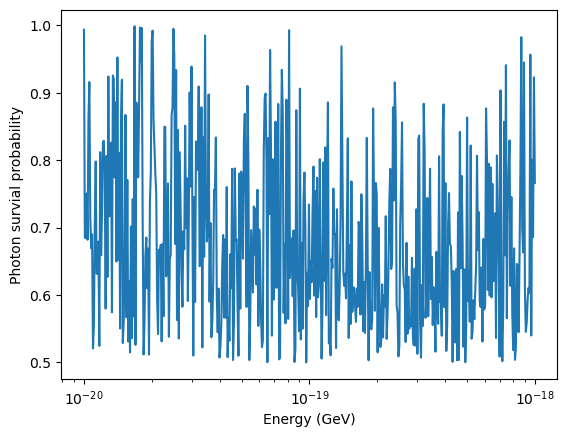

In [11]:
plt.semilogx(EGeV, px[0] + py[0])


#plt.legend()
#plt.gca().set_ylim(0.2,2.1)
plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survial probability')

### Gráfica más Completa

In [12]:
#calculamos mediana y STD

mediana = np.median(pa, axis=0)

sigma = np.std(1 - pa, axis=0)

Text(0, 0.5, 'Photon survial probability')

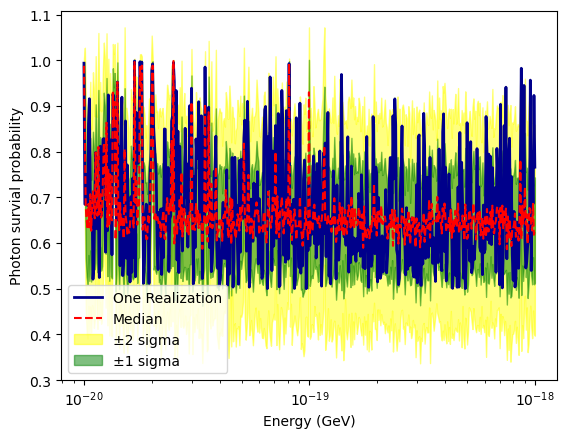

In [13]:
#actualizamos nuestra grafica


plt.semilogx(EGeV, px[0] + py[0],
             label='One Realization',
             color='darkblue',
             lw = 2
            )


plt.plot(ml.EGeV, (1-mediana),
        label='Median',
        linestyle='--',
        color='red')


plt.fill_between(EGeV, 1 - mediana - 2*sigma, 1 - mediana + 2*sigma, color='yellow', alpha=0.5, label='±2 sigma')

plt.fill_between(EGeV, 1 - mediana - sigma, 1 - mediana + sigma, color='green', alpha=0.5, label='±1 sigma')






plt.legend()
#plt.gca().set_ylim(0.25,2.1)
plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survial probability')

### Survival Probability with Turbulence

In [14]:
ml2 = ModuleList(alp, src, pin=pin, EGeV=EGeV, seed=0)

ml2.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=1e20,  # B field strength
                   L0=1e-9,  # cell size
                   nsim=1,  # realizations
                   n0=1e-3,  # electron density
                   r_abell=1e-6,  # full path
                   beta=0.,
                   eta=0.
                  )
ml2.add_propagation("ICMGaussTurb",
                  1, # position of module counted from the source.
                  nsim=100, # number of random B-field realizations
                  B0=1e6,  # rms of B field in muG
                  n0=3.9e-2,  # normalization of electron density in cm-3
                  n2=4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4 on cm-3
                  r_abell=1e-6, # extension of the cluster in kpc
                  r_core=8e-14,   # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  r_core2=4e-15, # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )


ml.add_propagation("GMF",2, model = 'jansson12', model_sym = 'BSS') # finally, the beam enters the Milky Way Field

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
environs.py: 431 --- INFO: Using inputted chi
environs.py:1196 --- INFO: Using inputted chi


In [15]:
px2, py2, pa2 = ml.run()
print (pa2.shape)

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
   core.py: 658 --- INFO: Running Module 1: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>


(50, 500)


Text(0, 0.5, 'Photon survial probability')

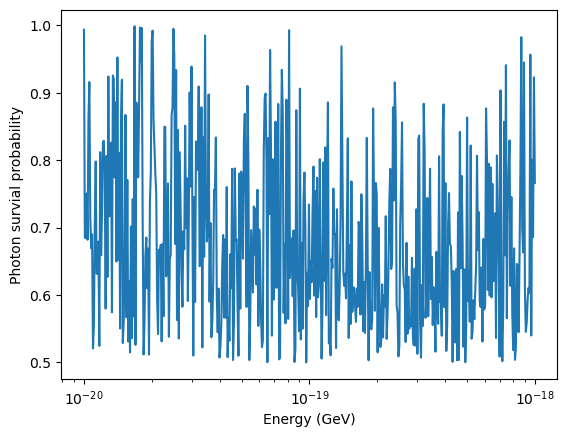

In [16]:
plt.semilogx(EGeV, px2[0] + py2[0])


#plt.legend()
#plt.gca().set_ylim(0.2,2.1)
plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survial probability')

In [17]:
#calculamos mediana y STD

mediana2 = np.median(pa2, axis=0)

sigma2 = np.std(1 - pa2, axis=0)

Text(0, 0.5, 'Photon survial probability')

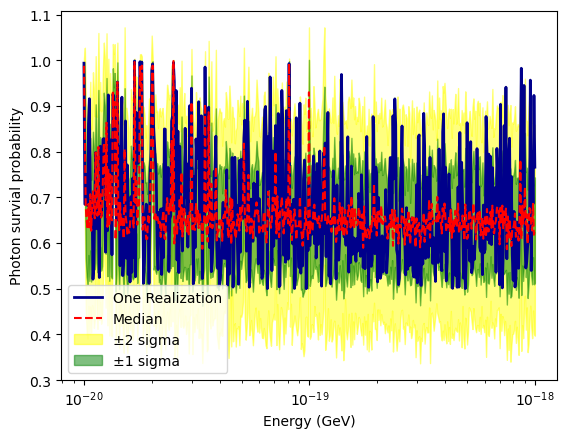

In [18]:
#actualizamos nuestra grafica


plt.semilogx(EGeV, px2[0] + py2[0],
             label='One Realization',
             color='darkblue',
             lw = 2
            )


plt.plot(ml2.EGeV, (1-mediana2),
        label='Median',
        linestyle='--',
        color='red')


plt.fill_between(EGeV, 1 - mediana2 - 2*sigma2, 1 - mediana2 + 2*sigma2, color='yellow', alpha=0.5, label='±2 sigma')

plt.fill_between(EGeV, 1 - mediana2 - sigma2, 1 - mediana2 + sigma2, color='green', alpha=0.5, label='±1 sigma')






plt.legend()
#plt.gca().set_ylim(0.25,2.1)
plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survial probability')

Now we step through some ALP masses and coupling constants and calculate the mixing probability

Let's compute a loop for al the different ALP masses

And also, and more useful, the `Photon survival probability` 

We can appreciate that for low masses such as `m = 0.1neV` or `m = 1 neV` the photon survival probability stays constant while for higher masses, we can see some fluctuations that decrease at higher energies. A decir verdad no entiendo por que se queda pillada la supervivencia en 0.55, preguntar por esto.